1. create conda env and activate
2. install 3.8.11 in conda env
3. install pip
4. install reqs

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training')) #needed for ai8x module to be loaded
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/models'))


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torchvision.io import read_image
import ai8x
from distiller import apputils
import pandas as pd
import matplotlib.pyplot as plt
import datasets.memes as memes
import numpy as np
from models import memenet


def printstats(variable):
    print("Shape: ", variable.shape)
    print("Max: ", variable.max())
    print("Min: ", variable.min())
    print("Mean: ", variable.mean())
    print("Variance: ", variable.var())
    

%matplotlib inline

### Expected Data Range

For training, input data is expected to be in the range  . When evaluating quantized weights, or when running on hardware, input data is instead expected to be in the native MAX7800X range of [-128, +127].

As described in the following sections, the data loader function takes the data path and some arguments as input arguments. The arguments field includes two required fields, act_mode_8bit and truncate_testset. When set to True, the first argument refers to the case normalization should be done correctly for the native MAX7800X range, i.e., to range [-128, +127]. When set to False, the normalization should be in the range of  for training.

If the available data is in the range of [0 1], e.g., as in PIL images, the data loader can directly call the ai8x.normalize() function to normalize the data to the two supported data ranges using the provided args argument:

class normalize:
"""
Normalize input to either [-128/128, +127/128] or [-128, +127]
"""
    def __init__(self, args):
        self.args = args

    def __call__(self, img):
        if self.args.act_mode_8bit:
            return img.sub(0.5).mul(256.).round().clamp(min=-128, max=127)
        return img.sub(0.5).mul(256.).round().clamp(min=-128, max=127).div(128.)

If the available data range is [0 255], it needs to be divided by 256 to bring it to the [0 1] range before calling the ai8x.normalize() function.

Note: The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. This method is used by training scripts with proper argument management, but if one calls the function externally, the simulate parameter should be set correctly.

When running inference on the MAX7800X hardware, it is essential to take the native data format into account, and it is desirable to perform as little preprocessing as possible during inference.



In [2]:
#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=False) #IMPORTANT: if this is not set to true, the test set will be float instead of int, and so you can't use the quantized model
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = memes.memes_get_datasets((data_path, args), load_train=True, load_test=True)

printstats(ds_train[2][1])

Shape:  torch.Size([3, 32, 32])
Max:  tensor(0.9531)
Min:  tensor(-1.)
Mean:  tensor(-0.5774)
Variance:  tensor(0.3048)


# Test on non quant model

In [3]:
#ai8x.set_device(85, True, True)  #IMPORTANT: SET SIMULATE PARAM, AS IT WILL OVERRIDE 8bit PARAM !!!!!!!! 
ai8x.set_device(85, False, True)  #use if quant

#The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. 

model = memenet.MemeNet(num_channels=3, dimensions=(32,32))
checkpoint_path = '../ai8x-training/logs/2024.01.09-161105/qat_best.pth.tar'
model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)

#read ood.png image 
ood_img = read_image('../ai8x-training/data/memes/test/ood2.png')
#convert from png to rgb
ood_img = ood_img[:3,:,:]
ood_img = transforms.functional.resize(ood_img, (32,32))

model.eval()
with torch.no_grad():

    sample_input2 = (ood_img.float() - 127)/255 # input from -1 to 1 is expected
    printstats(sample_input2)
    sample_output2 = model(sample_input2.unsqueeze(0)) #output from -1 to 1 is expected
    printstats(sample_output2)
    in_img2 = sample_input2.permute(1,2,0) + 0.5
    out_img2 = 255*(sample_output2.squeeze().permute(1,2,0) + 1)/2
    mse = torch.nn.MSELoss()

    fig2, ax2 = plt.subplots(1,2)
    ax2[0].imshow(in_img2)
    ax2[1].imshow(out_img2)
    ax2[0].set_title('OOD sample')
    ax2[0].set_title('OOD mse:%s'% np.round(mse(out_img2,in_img2).item(),4))
    
    #training set
    fig , ax= plt.subplots(10,2)
    fig.set_figheight(20)
    fig.set_figwidth(5)
    for i in range(10):
        idx=i
        sample_input = ds_train[idx][0] # input from -1 to 1 is expected
        in_img = sample_input.permute(1,2,0)
        in_img = (in_img + 1)*0.5 #now normalised from 0 to 1
        
        sample_output = (model(sample_input.unsqueeze(0))/128 +1)*0.5
        out_img = sample_output.squeeze().permute(1,2,0)

        ax[i][0].imshow(in_img)
        ax[i][1].imshow(out_img)
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        #title ax
        ax[i][0].set_title('Training sample')
        ax[i][1].set_title('MSE:%s'%np.round(mse(out_img,in_img).item(),4))
        

    #test set
    fig , ax= plt.subplots(10,2)
    fig.set_figheight(20)
    fig.set_figwidth(5)
    for i in range(10):
        idx=i
        sample_input = ds_test[idx][0] # input from -1 to 1 is expected
        in_img = sample_input.permute(1,2,0)
        in_img = (in_img + 1)*0.5 #now normalised from 0 to 1
        
        sample_output = (model(sample_input.unsqueeze(0))/128 +1)*0.5
        out_img = sample_output.squeeze().permute(1,2,0)

        ax[i][0].imshow(in_img)
        ax[i][1].imshow(out_img)
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        #title ax
        ax[i][0].set_title('Training sample')
        ax[i][1].set_title('MSE:%s'%np.round(mse(out_img,in_img).item(),4))
        

Configuring device: MAX78000, simulate=False.


FileNotFoundError: [Errno 2] Could not find a checkpoint file at: '../ai8x-training/logs/2024.01.09-161105/qat_best.pth.tar'

In [4]:
#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=True) #IMPORTANT: set to TRUE for quantization
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = memes.memes_get_datasets((data_path, args), load_train=True, load_test=True)

printstats(ds_train[2][1])

Shape:  torch.Size([3, 32, 32])
Max:  tensor(122.)
Min:  tensor(-128.)
Mean:  tensor(-73.8916)
Variance:  tensor(4996.5049)


### Test set evaluation of the quantized model

Configuring device: MAX78000, simulate=False.


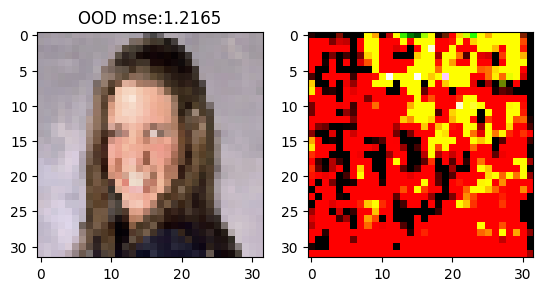

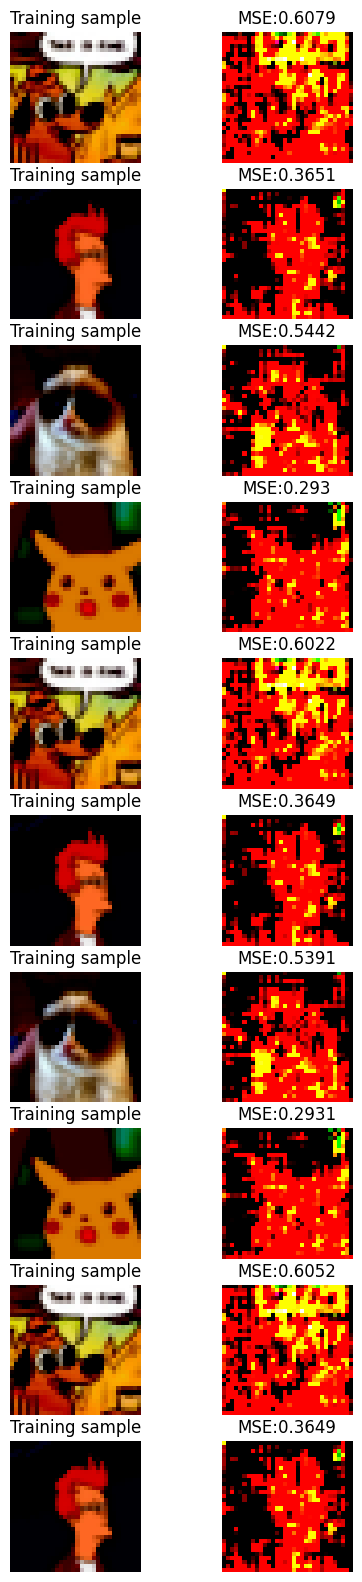

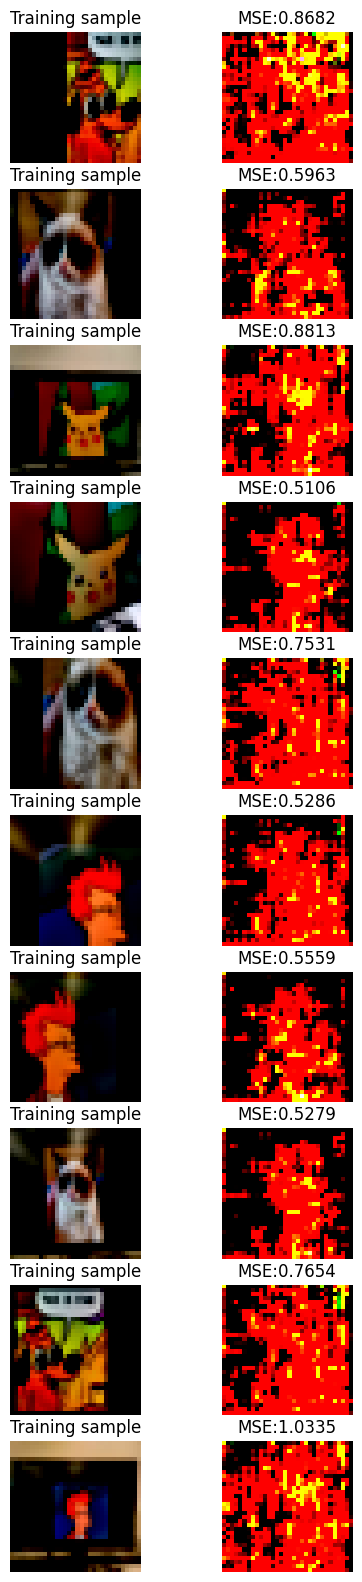

In [5]:
#ai8x.set_device(85, True, True)  #IMPORTANT: SET SIMULATE PARAM, AS IT WILL OVERRIDE 8bit PARAM !!!!!!!! 
ai8x.set_device(85, False, True)  #use if quant

#The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. 

model = memenet.MemeNet(num_channels=3, dimensions=(32,32))
checkpoint_path = '../ai8x-synthesis/trained/qat_best-q.pth.tar'
model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)

#read ood.png image 
ood_img = read_image('../ai8x-training/data/memes/test/ood.png')
#convert from png to rgb
ood_img = ood_img[:3,:,:]
ood_img = transforms.functional.resize(ood_img, (32,32))

model.eval()
with torch.no_grad():

    sample_input2 = (ood_img).float() - 127 #expected quant input range -127 to 128
    sample_output2_model = model(sample_input2.unsqueeze(0)) #output range -1 to 1
    sample_output2 = 255*(sample_output2_model+1)/2 #output range 0 to 255
    
    in_img2 = ood_img.permute(1,2,0) #0-255
    out_img2 = sample_output2.squeeze().permute(1,2,0)
    
    mse = torch.nn.MSELoss()

    fig2, ax2 = plt.subplots(1,2)
    ax2[0].imshow(in_img2.int())
    ax2[1].imshow(out_img2.int())
    ax2[0].set_title('OOD sample')
    ax2[0].set_title('OOD mse:%s'% np.round(mse(sample_input2/128,sample_output2_model).item(),4))
    
    #training set
    fig , ax= plt.subplots(10,2)
    fig.set_figheight(20)
    fig.set_figwidth(5)
    for i in range(10):
        idx=i
        sample_input = ds_train[idx][0] #expected quant input range -128 to 127/128
        sample_output_model = model(sample_input.unsqueeze(0)) #output range -1 to 1
        sample_output = 255*(sample_output_model+1)/2 #output range 0 to 255

        in_img = sample_input.permute(1,2,0)+ 128 #0-255
        out_img = sample_output.squeeze().permute(1,2,0) #0-255
        
        ax[i][0].imshow(in_img.int())
        ax[i][1].imshow(out_img.int())
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        #title ax
        ax[i][0].set_title('Training sample')
        ax[i][1].set_title('MSE:%s'%np.round(mse(sample_input/127,sample_output_model).item(),4))
        
        
        
    #test set
    fig , ax= plt.subplots(10,2)
    fig.set_figheight(20)
    fig.set_figwidth(5)
    for i in range(10):
        idx=i
        sample_input = ds_test[idx][0] #expected quant input range -128 to 127/128
        sample_output_model = model(sample_input.unsqueeze(0)) #output range -1 to 1
        sample_output = 255*(sample_output_model+1)/2 #output range 0 to 255

        in_img = sample_input.permute(1,2,0)+ 128 #0-255
        out_img = sample_output.squeeze().permute(1,2,0) #0-255
        
        ax[i][0].imshow(in_img.int())
        ax[i][1].imshow(out_img.int())
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        #title ax
        ax[i][0].set_title('Training sample')
        ax[i][1].set_title('MSE:%s'%np.round(mse(sample_input/127,sample_output_model).item(),4))

In [ ]:
test_set_len = len(ds_test)
misclassified_cnt = 0
classification_cnt = 0

for i in range(test_set_len):
    img, label = ds_test[i]
    img_model = img.unsqueeze(0)
    pred = model(img_model)
    pred_label = pred.argmax(dim=1).squeeze().item()
    print('%s. Predicted: %s, true: %s' % (i, pred_label, label))
    if pred_label != label:
        misclassified_cnt += 1
    else:
        classification_cnt += 1

print('Misclassified: %d, Classified: %d' % (misclassified_cnt, classification_cnt))